In [29]:
using Plots
import Statistics: mean
import Random: seed!
pyplot(legend = false)



mutable struct Capa
    W::Matrix{Float64}
    b::Vector{Float64}
    
    # función de activación
    f::Function
    
    # derivada función de activación
    df::Function
end



# Función de activación

$$
    \text{sigmoide}(x) =  \dfrac{1}{e^{-x} + 1}
$$

In [30]:
sigmoid(x) = 1.0 ./ (exp.(-x) .+ 1)

# derivada
∂sigmoid(x) = x .* (1.0 .- x)

∂sigmoid (generic function with 1 method)

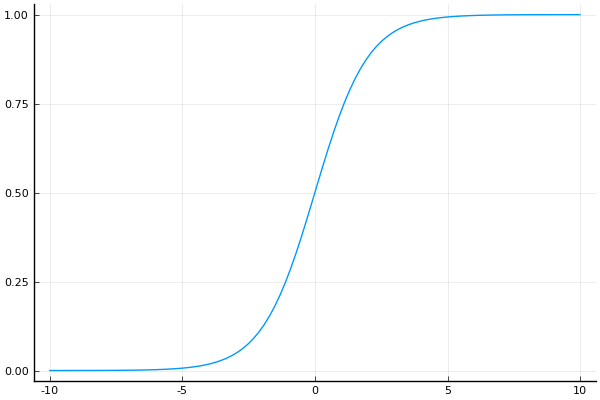

In [31]:
x = range(-10, 10, length=100)
plot(x, sigmoid(x))

## Función de costo/pérdida

Error cuadrático medio
$$
    \text{costo}(\hat{y}, y) = \dfrac{1}{N} \sum_{i=1}^N (\hat{y}_i - y_i)^2 
$$

In [32]:

# Error cuadrático medio
costo(ŷ, y) = mean( (y - ŷ).^2 )

# derivada del error cuadrático medio
∂costo(ŷ, y) = (ŷ - y)


∂costo (generic function with 1 method)

In [33]:
# Crea una capa
function Capa(n_entradas::Int, n_salidas::Int; f = sigmoid, df = ∂sigmoid)
    W = -1.0 .+ 2.0rand(n_entradas, n_salidas)
    b = -1.0 .+ 2.0rand(n_salidas)
    
    Capa(W, b, f, df)
end


genera_red(topología) = [ Capa(topología[i], topología[i+1]) for i in 1:length(topología)-1 ]



genera_red (generic function with 1 method)

# Topología
Para generar una red con capas ocultas, podemos especificar los tamaños de las capas en un arreglo de enteros. Por ejemplo `topología = [2,3,4,1]` significa que el capa entrada es 2, seguida de dos capas ocultas con 3 y 4 neuronas y la capa de salida tiene una neurona. 

## Paso hacia adelante

Solo es evaluar los datos en la red

In [34]:
function hacia_adelante(X, red)
    salidas = [(zeros(0, 0), X)]
    
    
    for i in 1:length(red)
        z = salidas[end][2] * red[i].W  .+ red[i].b'
        a = red[i].f.(z)
        
        push!(salidas, (z, a) )
    end
    
    return salidas
end

function predice(X, red)
    s = hacia_adelante(X, red)
    return s[end][2]
end






predice (generic function with 1 method)

## Propagación hacia atrás

In [35]:
# η es un parámetro llamado tasa de aprendizaje 
# usualmente se ajusta a mano

function entenamiento_hacia_atrás!(X, Y, red; η = 0.005)
    # Primero se hace el paso hacia adelante 
    salidas = hacia_adelante(X, red)

    deltas = []
    _W = nothing

    for i in length(red):-1:1
        
        z, a = salidas[i+1]
        
        if i == length(red)
            # derivada del costo respecto la capa de salida
            push!(deltas, (∂costo(a, Y) .* red[i].df.(a))')
        else
            # derivada del costo de la capa i respecto la capa i - 1
            push!(deltas,   (_W * deltas[end] ) .* red[i].df.(a)' )
        end

        
        _W = red[i].W
        
        # gradiente descendiente
        red[i].b = red[i].b .-  η * mean(deltas[end], dims=1)[:,1]
        red[i].W = red[i].W - η * ( deltas[end] * salidas[i][2]   )'
        

        
    end
end

entenamiento_hacia_atrás! (generic function with 1 method)

## Ejercicio del artículo

In [36]:
seed!(0)
topología_ejercicio = [3, 2, 3]

X_ejercicio = [1 0.25 -0.5]
Y_ejercicio = [1  -1   0.0]

# escalamiento a intervalo [0, 1] por la sigmoide
Y_ejercicio = (1 .+ Y_ejercicio)/2

red_ejercicio = genera_red(topología_ejercicio)
iteraciones_ = 500

convergencia_ejercicio = []
for t in 1:iteraciones_
    entenamiento_hacia_atrás!(X_ejercicio, Y_ejercicio, red_ejercicio, η = 1.0)
    ŷ = predice(X_ejercicio, red_ejercicio)
    push!(convergencia_ejercicio, costo(ŷ, Y_ejercicio))
end
    ŷ = predice(X_ejercicio, red_ejercicio)

@show costo(ŷ, Y_ejercicio)

ŷ = 2predice(X_ejercicio, red_ejercicio) .- 1
@show ŷ

costo(ŷ, Y_ejercicio) = 0.0003814789139669241
ŷ = [0.952870061554671 -0.9514561107772526 8.178552569848563e-5]


1×3 Array{Float64,2}:
 0.95287  -0.951456  8.17855e-5

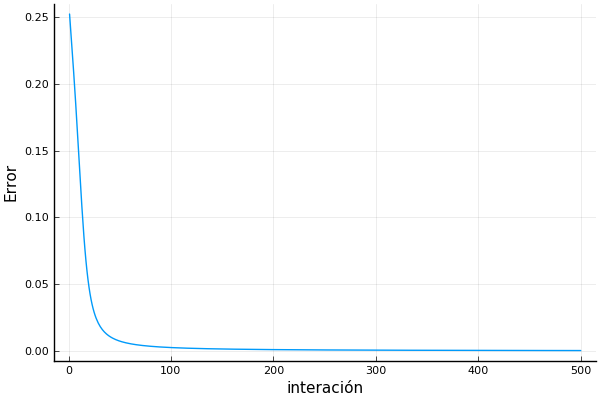

In [37]:
# la convergencia puede depender de η
plot(convergencia_ejercicio, xlabel="interación", ylabel="Error")

## Ejemplo Interesante

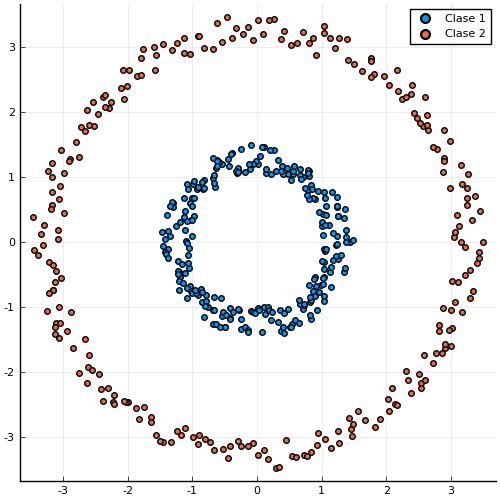

In [38]:
# número de datos
n = 250

# anillo 1
X1 = [ (1 .+ 0.5rand(n)).*cos.(range(0,2π, length=n)) (1 .+ 0.5rand(n)).*sin.(range(0,2π, length=n)) ] 
Y1 = zeros(n)


# anillo 2
X2 = [ (3 .+ 0.5rand(n)).*cos.(range(0,2π, length=n)) (3 .+ 0.5rand(n)).*sin.(range(0,2π, length=n)) ] 
Y2 = ones(n)

# datos entrenamiento
X = vcat(X1, X2)
Y = vcat(Y1, Y2)

scatter(X1[:,1], X1[:,2], size=(500, 500),legend=true, label="Clase 1")
scatter!(X2[:,1], X2[:,2], size=(500, 500),legend=true, label="Clase 2")

In [39]:
# 
seed!(0)

topología = [2,94,1]

red = genera_red(topología)
iteraciones = 1500

# para generar la animación
convergencia = []
convergencia_modelo = []

# ciclo de entrenamiento
for t in 1:iteraciones
    entenamiento_hacia_atrás!(X, Y, red, η = 0.001)
    ŷ = predice(X, red)
    
    push!(convergencia, costo(ŷ, Y))
    push!(convergencia_modelo, deepcopy(red))
 end

println("Listo, costo: ", minimum(convergencia))


Listo, costo: 0.022000486802573483


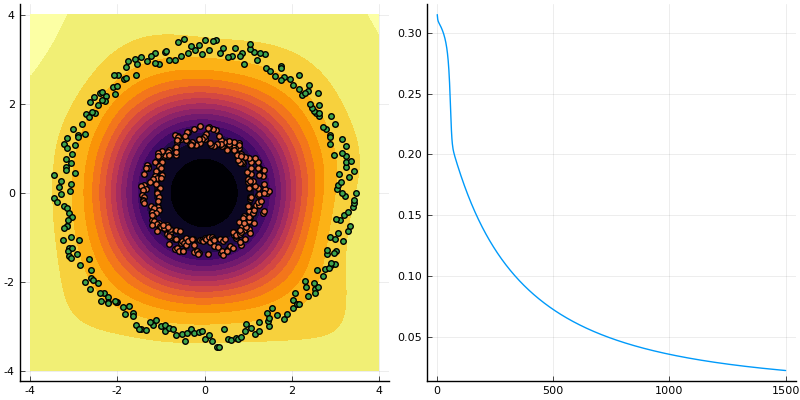

In [40]:
a = b = range(-4, 4, length=100)

l = @layout [a b]
p = plot(layout = l, size=(800, 400))
contourf!(p[1], a, b, (a,b)->predice([a b], convergencia_modelo[argmin(convergencia)])[1] )

scatter!(p[1], X1[:,1], X1[:,2])
scatter!(p[1], X2[:,1], X2[:,2])
plot!(p[2], convergencia)

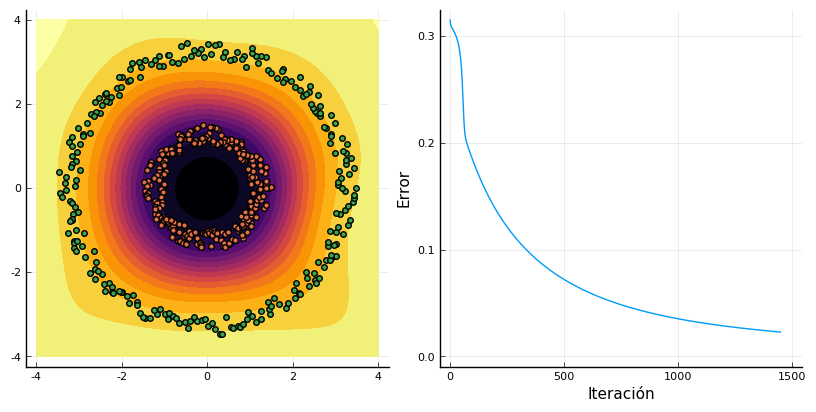

┌ Info: Saved animation to 
│   fn = /home/sague/Documents/neuronales/tmp.gif
└ @ Plots /home/sague/.julia/packages/Plots/Xnzc7/src/animation.jl:104


Plots.AnimatedGif("/home/sague/Documents/neuronales/tmp.gif")
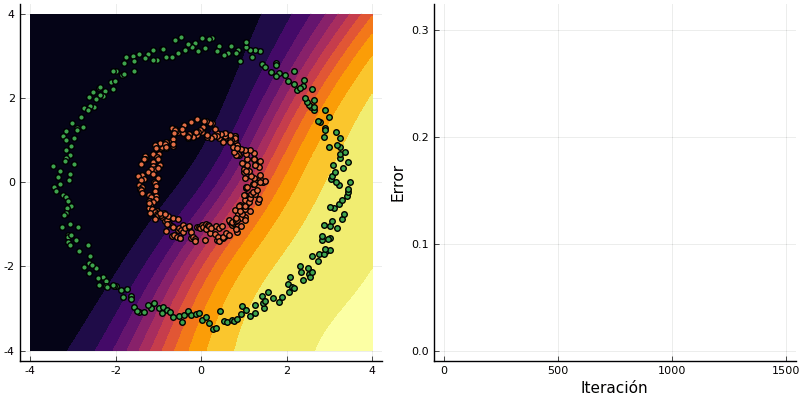

In [41]:
# animación

n_imagenes = 30 # estre más grande es este número más tarda en dibujar pero la visualización se logra apreciar
duración_video = 5 # segundos

s = round(Int, length(convergencia) / n_imagenes)

anim = @animate for i in 1:s:length(convergencia)
    l = @layout [a b]
    p = plot(layout = l, size=(800, 400))
    contourf!(p[1], a, b, (a,b)->predice([a b], convergencia_modelo[i])[1] )

    scatter!(p[1], X1[:,1], X1[:,2])
    scatter!(p[1], X2[:,1], X2[:,2])
    plot!(p[2], convergencia[1:i], xlims=[0, iteraciones], ylims=[0,maximum(convergencia)], xlabel="Iteración", ylabel="Error")
end

gif(anim, fps = floor(Int, n_imagenes / duración_video))

In [42]:
# las oscilaciones son por la inicialización y por η